In [54]:
import numpy as np
import pandas as pd
import time
import math
import matplotlib.pyplot as plt
import seaborn  as sns
from sklearn.metrics import confusion_matrix
print("Done!")

Done!


In [72]:
"""Variables and parameters """
#these are values used to generate noise
NOISE_MEAN = 0
NOISE_STD_DEV = 15

COMMON_THRESHOLD = 5000 #trigger threshold --not used here
DELAY_PERIOD= 70 #the delay of time to wait when a threshold is exceeded -- not used here
LOW_AMPLITUDE, HIGH_AMPLITUDE = 35, 75 # the upper limit and lower limit of the amplitudes of the random pulses

FREQUENCY= 3.2e9 #frequency in GHz

ENVELOPE_RANGE=10
PLOT_Y_LIMS= -200,8000   #-100,1500
PULSE_LIKELIHOOD= 2 #probability of occurance of random pulses (Higher makes it less probable, n is around 1 occurance per n cycles)
PLOT_SIZE= 1000 #Data points in one plot
max_size= 3000 #the maximum number of points in the signal arrays kept at any time (this includes t_axis) (to protect the RAM)
n_of_plots=16 #number of channels and plots
PULSE_DURATION=40 #the length of each generated signal/ pulse if less than 30 it would clearly cutoff the signals
SUPERPOSITION_FACTOR= 3 #the maxiumum number of super-imposed signals in each channel

print("Done!")


Done!


In [5]:
"""Classes """
class WaveAmplitude: #class for generating random numbers used as the amplitude of a signal
    def __init__(self, value=0 ):
        self.value=np.random.randint(LOW_AMPLITUDE, HIGH_AMPLITUDE)
    def generate_new(self):
        self.value=np.random.randint(LOW_AMPLITUDE, HIGH_AMPLITUDE)


class WaveProgression: #this class is for counters used in generating the pulses
    def __init__(self, value:int=0):
        self.value=0
    def plus_one(self):
        self.value +=1
    def reset(self):
        self.value=0
    def change(self,const):
        self.value=const


class PulseExistence(): #This is used for knowing if a pulse is happening and the code will keep generating the pulse if the value is True
    def __init__(self, state:bool=False):
        self.state=False
    def set_true(self):
        self.state=True
    def set_false(self):
        self.state=False

print("Done!")

Done!


In [31]:
"""Function """
#not used here
def display_stats(signal, t_axis, threshold, PLOT_SIZE):
    if round(t_axis[-1]*FREQUENCY)%PLOT_SIZE==0:

        print("plot n°: ", t_axis[-1] // PLOT_SIZE)
        print("--------------------------------------------------------")

        plt.plot(t_axis[-PLOT_SIZE:], signal[-PLOT_SIZE:])
        plt.xlabel("Time (ns)")
        plt.ylabel("Voltage (mV)")
        plt.axhline(y=threshold, color='r', lw=1, linestyle='--')
        plt.grid(True, lw=0.5)
        plt.title("Random signal and random pulses")
        plt.show()

def display_n_plots(t_axis,signals,PLOT_SIZE):
    if round(t_axis[-1]*FREQUENCY)%PLOT_SIZE==0:
        print("plot n°: ", t_axis[-1] // PLOT_SIZE)
        print("--------------------------------------------------------")
        fig, axs = plt.subplots(4, 4, figsize=(12, 12))  # Adjust the figure size
        y_limits = (-250, 250)
        for i, ax in enumerate(axs.flat):
            ax.plot(t_axis[-PLOT_SIZE:], signals[i][-PLOT_SIZE:], label=f'Channel {i}')
            ax.set_title(f'Channel {i + 1}', fontsize=10)
            ax.set_ylim(y_limits)
            ax.grid(True, lw=0.5)
            ax.label_outer()  # Only show outer labels to avoid redundancy
        fig.suptitle('16 Controlled channels', fontsize=22)  # Add a super title
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit super title


        #plt.savefig(f'Figure {int(t_axis[-1] //200)+1} w 16 Controlled channels')
        plt.show()

def display_n_plots_envelope(t_axis,signals,threshold,plot_size,envelopes,PLOT_Y_LIMS,envelope_range):
    if round(t_axis[-1]*FREQUENCY)%plot_size==0:
        print("plot n°: ", t_axis[-1] // plot_size)
        print("--------------------------------------------------------")
        fig, axs = plt.subplots(4, 4, figsize=(12, 12))  # Adjust the figure size

        upper_index=(envelope_range//2)

        y_limits = (PLOT_Y_LIMS[0], PLOT_Y_LIMS[1])

        if round(t_axis[-1]*FREQUENCY)//plot_size>1:
            #all other plots
            bound_1=envelope_range+upper_index
            bound_2=envelope_range
            t_bound=plot_size+upper_index
        else:
            #just for the first plot
            bound_1= upper_index
            bound_2=1
            t_bound=plot_size

        for i, ax in enumerate(axs.flat):
            ax.plot(t_axis[-plot_size:], signals[i][-plot_size:], label=f'Channel {i + 1}')
            ax.plot(t_axis[-t_bound:-bound_1], envelopes[i][-plot_size:-bound_2])

            ax.set_title(f'Channel {i + 1}', fontsize=10)
            ax.set_ylim(y_limits)
            ax.axhline(y=threshold, lw=1,color='r', linestyle='--')
            ax.grid(True, lw=0.5)
            ax.label_outer()  # Only show outer labels to avoid redundancy
        fig.suptitle('16 Controlled channels', fontsize=22)  # Add a super title
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit super title

        plt.savefig(f'Envelope_plots_{int(t_axis[-1] //200)+1}_16_channels')
        plt.show()

def smart_append(t_axis,array,new_point,max_size):
    if round(t_axis[-1]*FREQUENCY)<=max_size:
    #if len(t_axis)<=max_size:
        array=np.append(array,new_point)
    else:
        array=np.append(array[1:], new_point)
    return array


def multiple_pulse_generator(SUPERPOSITION_FACTOR, PULSE_LIKELIHOOD, PULSE_DURATION, PLOT_SIZE,pulse_existence_local, wave_counts_local ,pulse_amplitudes_local ):

    pulses=[]
    for i in range(SUPERPOSITION_FACTOR):
        if pulse_existence_local[i].state==False:
            sig=0
            wave_counts_local[i].reset()
            if np.random.randint(PULSE_LIKELIHOOD*PLOT_SIZE)==1:
                pulse_existence_local[i].set_true()

        else:
            sig=burst_waveform(wave_counts_local[i].value , pulse_amplitudes_local[i].value)

            wave_counts_local[i].plus_one()
            if wave_counts_local[i].value>PULSE_DURATION:
                pulse_existence_local[i].set_false()
                pulse_amplitudes_local[i].generate_new()

        pulses.append(sig)
    return np.sum(pulses)

def signal_generator( noise_mode,real_noise_index,real_noise_data,NOISE_MEAN, NOISE_STD_DEV, pulse_existence,wave_counts, pulse_amplitudes, PULSE_LIKELIHOOD,SUPERPOSITION_FACTOR, PULSE_DURATION):

    if noise_mode=="random_noise":
        noise_value = np.random.normal(loc=NOISE_MEAN, scale=NOISE_STD_DEV) #this generates the background noise
    elif noise_mode=="zero_noise":
        noise_value = 0
    elif noise_mode=="real_noise":
        noise_value = real_noise_data[real_noise_index.value]
        real_noise_index.plus_one()


    pulses = multiple_pulse_generator(SUPERPOSITION_FACTOR, PULSE_LIKELIHOOD, PULSE_DURATION,PLOT_SIZE,pulse_existence, wave_counts, pulse_amplitudes) #this makes sure that the simulated signal is random and is able to have multiple superposed pulses.

    next_point= noise_value + pulses

    return next_point**2

def envelope(signal,ENVELOPE_RANGE ):
    return np.sum(signal[-ENVELOPE_RANGE:])/ENVELOPE_RANGE

print("Done!")

Done!


In [7]:
"""This is for recording the pulse generation states to know if a signal is active or not"""
def pulse_existence_recorder(list,states):

    new_states=np.any([existence.state for existence in states])

    return np.append(list,new_states)

In [8]:
"""This cell is for the L1 - L4 Trigger system"""
"""I will be dealing with signals[n] (from 0 to 15) as a  list of 16 channels"""

""" Channels 0 - 15: have special indices:
0:3 -- S1_Vtop, S1_Vbot, S2_Vtop, S2_Vbot
4:7 --  S3_Vtop, S3_Vbot, S4_Vtop, S4_Vbot
8:11 -- S1_Htop, S1_Hbot, S2_Htop, S2_Hbot
12:15 --  S3_Htop, S3_Hbot, S4_Htop, S4_Hbot
 """

"""For the list -L1- it has 15 binary values, the indices describe the L1 condition in that order"""

"""The list -Groups- is used to record the indices for L2; it has coordinates for the groups in this order:
S_1/2_|V|  ,  S_3/4_|V|  ,  S_1/2_|H|  ,  S_3/4_|H|
"""

"""The list -L2- is used to hold binary conditions of the states of the L2 triggers arranged in the same order as -Groups-"""

"""The list -L2_level- holds information about the level of trigger of L2;
level 1 if it is due to only one L1 trigger in the group;
level 2 if 2 L1 triggers in the group;
level 3 if 3 L1 triggers in the group
This information is held as an int
"""

"""The list -L3- is used to hold binary conditions of the states of the L3 triggers in this order
[0] is Vertical
[1] is Horizontal
"""

"""L4 is just one condition for the state of the L4 trigger"""

"""All The L1 states also have counters That make sure that the list keeps track of the progression and knows how long the window has been open"""

L1=[]
L1_counters=[]

Groups=[[0,1,2,3],[4,5,6,7],[8,9,10,11],[12,13,14,15]]
L2=[]
L2_level=[]

L3=[]

L4=PulseExistence()

#filling ip the lists with the classes
for i in range(16): #for all 16 L1 triggers
    L1.append(PulseExistence())
    L1_counters.append(WaveProgression())

for i in range(4): #for all 4 L2 triggers
    L2.append(PulseExistence())
    L2_level.append(WaveProgression())

for i in range(2): #for all 2 L3 triggers
    L3.append(PulseExistence())

#L4 is defined above

print("Done!")

Done!


In [9]:
"""L triggers and logic"""
"""There are 4 main functions to set the states of the L triggers with no return/output"""
#sets all 16 L1 states
def L1_setter(signals, L1, L1_counter, threshold_list, DELAY_PERIOD):
    for i in range (n_of_plots):
        if signals[i][-1]>=threshold_list[i] and L1[i].state==False:
            L1[i].set_true()
        elif L1[i].state==True:
            L1_counter[i].plus_one()
            if L1_counter[i].value >= DELAY_PERIOD:
                L1[i].set_false()
                L1_counter[i].reset()

#sets all 4 L2 states
def L2_setter(L1, L2, L2_level, Groups):
    for i, group in enumerate(Groups):
        thresholds_exceeded=np.sum([L1[i].state for i in group])

        if thresholds_exceeded>0:
            L2[i].set_true()
            L2_level[i].change(thresholds_exceeded)

        else:
            L2[i].set_false()
            L2_level[i].reset()

#sets all 2 L3 states
def L3_setter(L3, L2_level):
    """This function sets the L3 states according to how many L2s have exceeded the 3 count"""
    L3[0].set_true() if L2_level[0].value + L2_level[1].value >= 3 else L3[0].set_false() #This is for L3 V_pol
    L3[1].set_true() if L2_level[2].value + L2_level[3].value >= 3 else L3[1].set_false() #This is for L3 H_pol

def L4_setter(L3, L4):
    L4.set_true() if L3[0].state or L3[1].state else L4.set_false()

def L_Triggers(signals, L1, L1_counter, threshold, delay_period, L2, L2_level, L3, L4, Groups):
    L1_setter(signals, L1, L1_counter, threshold, delay_period)
    L2_setter(L1, L2, L2_level, Groups)
    L3_setter(L3, L2_level)
    L4_setter(L3, L4)

    return [L.state for L in L2 + L3] + [L4.state]

def L1_Triggers_returns(signals, L1, L1_counter, threshold, DELAY_PERIOD):
    L1_setter(signals, L1, L1_counter, threshold_list, DELAY_PERIOD)
    return [L.state for L in L1]


print("Done!")

Done!


In [10]:
"""This helps plot the states of the L_triggers"""

L_name=["L2_0","L2_1","L2_2","L2_3","L3_Vpol","L3_Hpol","L4"] #used in plots to show which L trigger is being displayed

L1_names=[]

L1_names=[f"L1_{i}" for i in range(n_of_plots)] #similar with this, just the names of the triggers to be diplayed


#this function is for plotting the L triggers for
# L1 if you use states=L_1_states and L_name= L1_names

#or L2, L3 and L4 (four L2s, two L3s and one L4) 7 total
# if states= L_2_3_4_states and L_name=L_name

def plot_L_states(t_axis,states, L_name,PLOT_SIZE,mode,name):
    if round(t_axis[-1]*FREQUENCY)%PLOT_SIZE==0:
        print("plot n°: ", t_axis[-1] // PLOT_SIZE)
        print("--------------------------------------------------------")
        y_limits = (-0.2, 1.3)
        subplots=len(states)
        fig, axs = plt.subplots(subplots, 1, figsize=(4, 12))  # Adjust the figure size
        for i, ax in enumerate(axs.flat):
            binary_values = [1 if x else 0 for x in states[i]]
            ax.plot(t_axis[-PLOT_SIZE:], binary_values[-PLOT_SIZE:], label=L_name[i])
            ax.set_title(L_name[i], fontsize=10)
            ax.set_ylim(y_limits)
            plt.legend()
            ax.grid(True, lw=0.5)
            ax.label_outer()  # Only show outer labels to avoid redundancy
        fig.suptitle('16 Controlled channels', fontsize=22)  # Add a super title
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit super title

        if mode=="save":
            filename=name+"_"+str(t_axis[-1]//PLOT_SIZE)
            plt.savefig(filename)
            plt.clf()
        elif mode=="show":
            plt.show()


In [11]:
"""Function to randomise noise selection"""

def segment_and_shuffle(data, segment_size):
    """
    Segments each channel in the data into chunks, shuffles the chunks,
    and then reconstructs the channels while keeping the order within chunks.

    Parameters:
        data (np.ndarray): Input array of shape (channels, points).
        segment_size (int): Size of each segment.

    Returns:
        np.ndarray: Array with shuffled segments, same shape as input.
    """
    # Initialize the list to store shuffled data for each channel
    shuffled_data = []

    # Iterate over each channel
    for channel in data:
        # Segment the channel into chunks of size segment_size
        segments = [channel[i:i + segment_size] for i in range(0, len(channel), segment_size)]

        # Shuffle the order of segments
        np.random.shuffle(segments)

        # Flatten the list of shuffled segments back into a 1D array
        shuffled_channel = np.concatenate(segments)

        # Ensure that the reshaped channel has the same length as the original
        if len(shuffled_channel) > len(channel):
            shuffled_channel = shuffled_channel[:len(channel)]

        # Append the shuffled channel to the list
        shuffled_data.append(shuffled_channel)

    # Convert the list back into a numpy array and return
    return np.array(shuffled_data)


In [12]:
""" Different waveforms """
def burst_waveform( time, amp ):
    A = amp
    B = 10.0
    C = 10.0
    omega = 1.2
    k = 1.0

    cosine_term   = A * math.cos( omega * time )      # oscillation
    heaviside_term = 1 / (1 + math.exp( -2*k*time ) ) # turn-on (heaviside step function parameterized)
    exponent_term = math.exp( -(time - B)/C )         # attenuation

    voltage = cosine_term * heaviside_term * exponent_term
    return voltage

print("Done!")

Done!


In [13]:
"""Graph parameters"""

graph_state="show" #you can either choose to save or graph the plots (choose "show" or "save" )
graph_save_name="3hpoltst" #The name of the plot files if saved (it will be followed by a number in order: 1, 2 ,3)
graph_count=3   #number of plots to generate and graph
noise_mode="real_noise" #choose noise mode options: "zero_noise"  "random_noise" "real_noise" (from real ARA data)


In [14]:
"""Real data import module"""

data=pd.read_pickle("noise_data1.pkl")
data=np.array(data)
data=np.transpose(data) #Now the data is in the preferred shape

noise_ara_data=segment_and_shuffle(data, segment_size=100000) #this function cuts the data file into segments and mixes them. This allows for a new set of noise every simulation (len of data points: 2,098,176)

plot n°:  0.0
--------------------------------------------------------


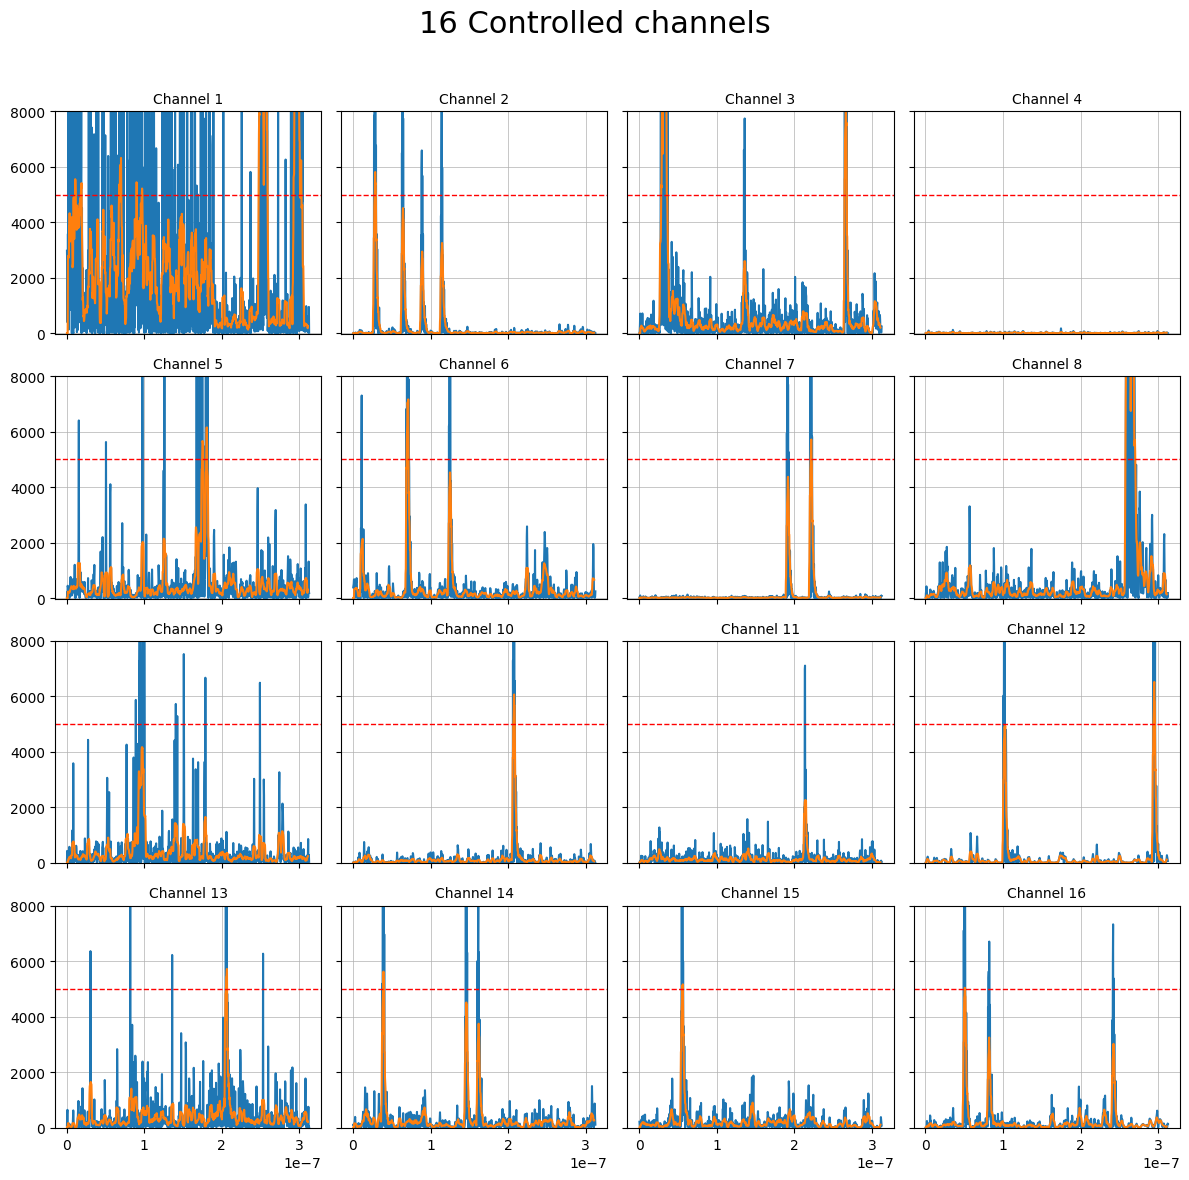

plot n°:  0.0
--------------------------------------------------------


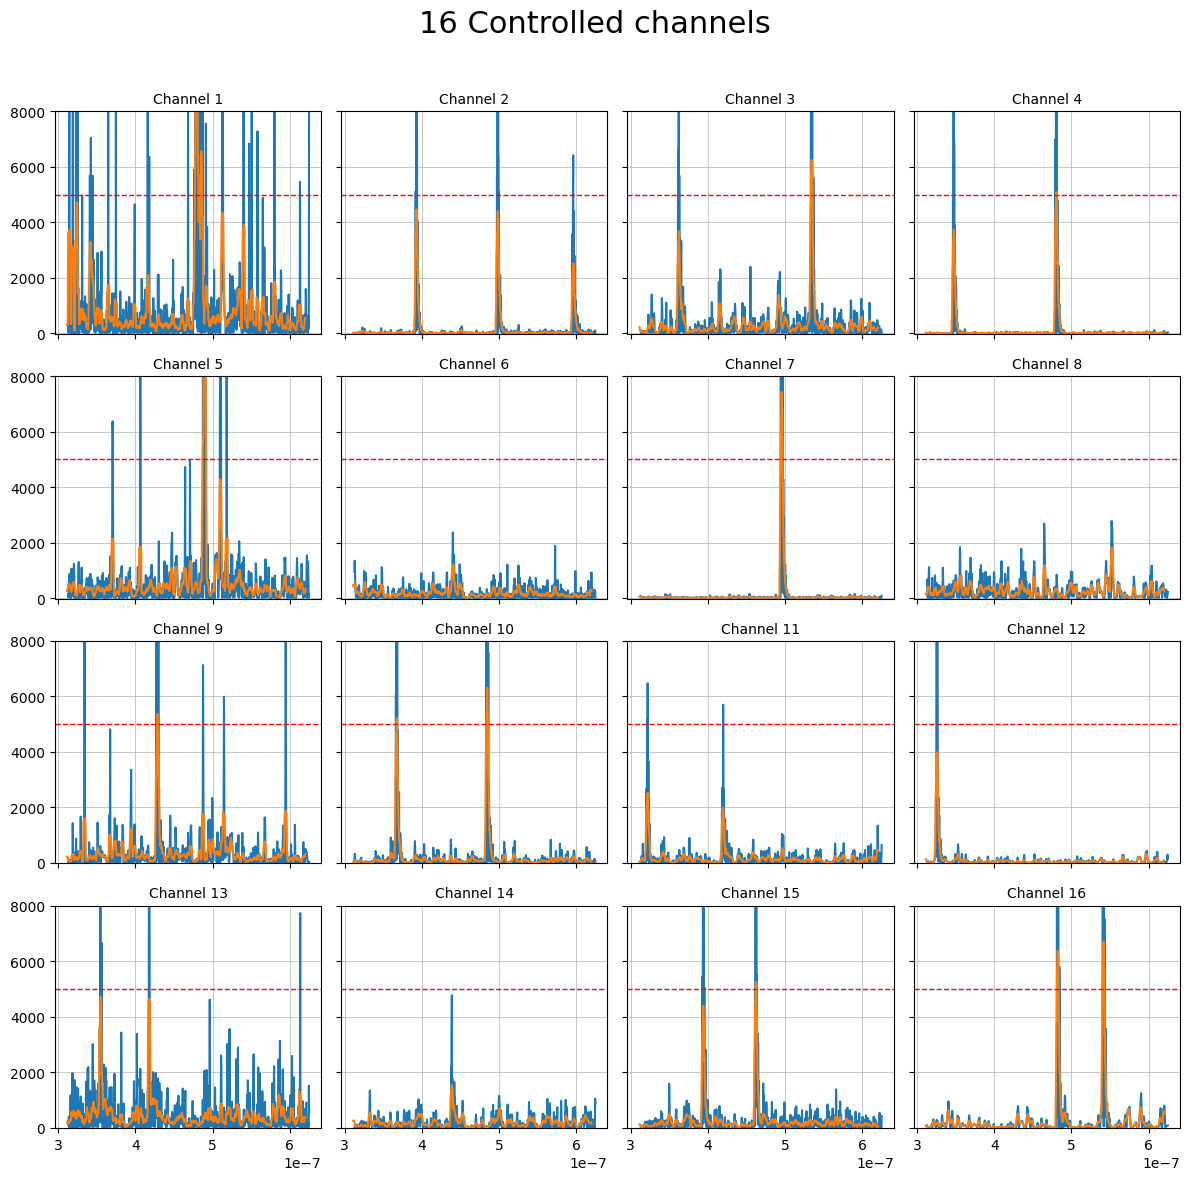

plot n°:  0.0
--------------------------------------------------------


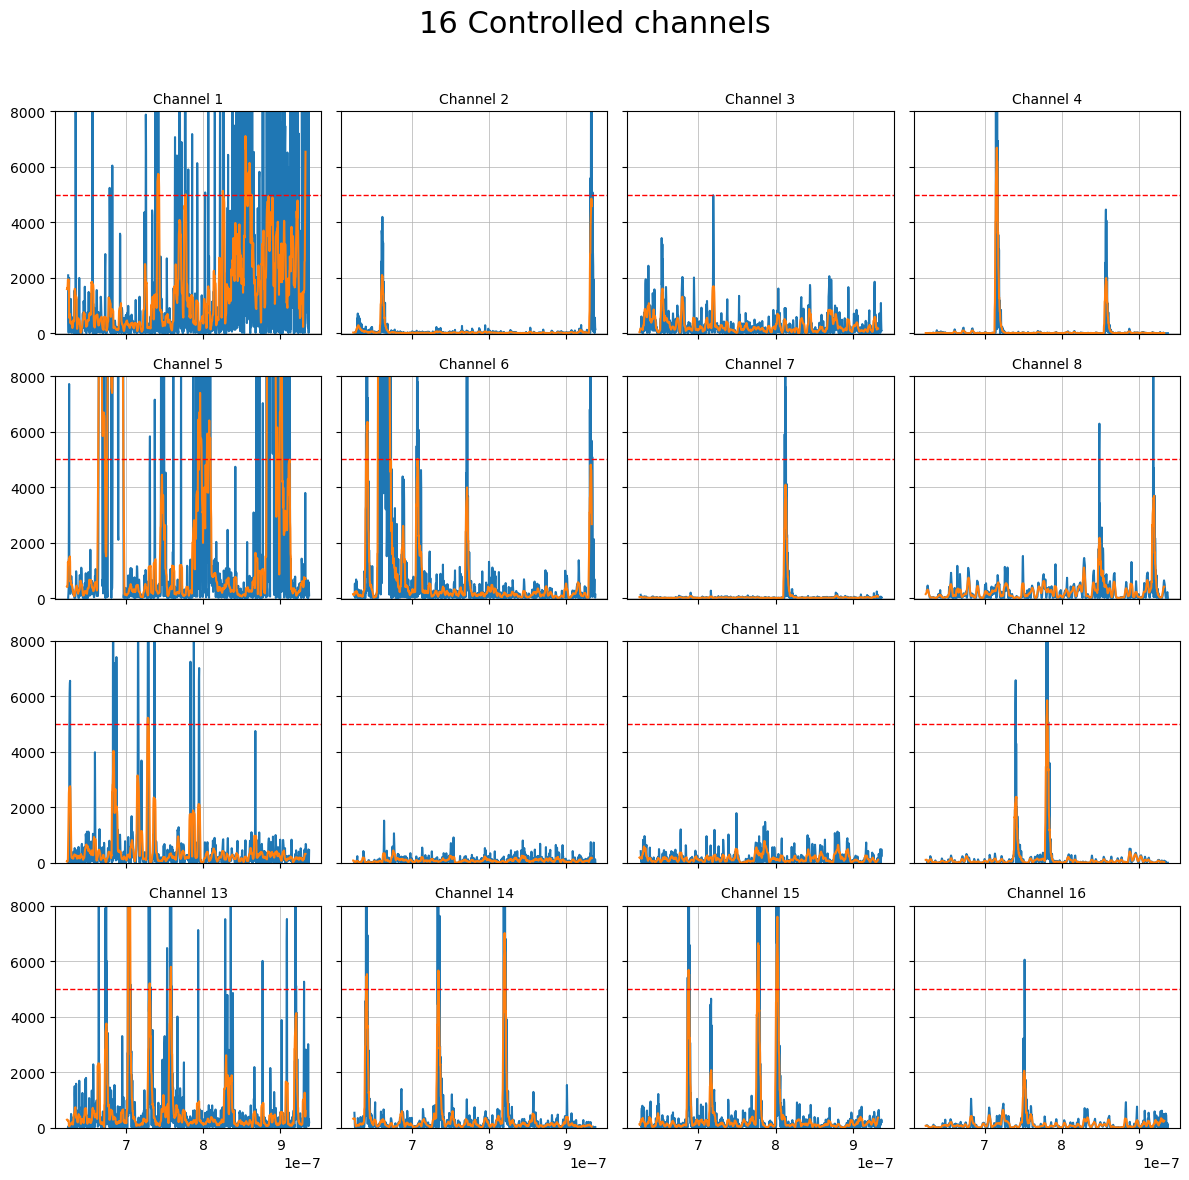

Done!


In [74]:
"""Compiler """

t_axis = np.array([0]) #This is the general time axis that is common for all channels
threshold_list=np.ones(n_of_plots) * COMMON_THRESHOLD
pulse_amplitudes, wave_counts, pulse_existence= [], [], []  #the conditions that help track the progression of the signals using the classes

for i in range(n_of_plots): #this creates elements from the classes to keep track of the progression of the waveforms

    pulse_amplitudes.append([WaveAmplitude() for i in range(SUPERPOSITION_FACTOR)])
    wave_counts.append([WaveProgression() for i in range(SUPERPOSITION_FACTOR)])
    pulse_existence.append([PulseExistence() for i in range(SUPERPOSITION_FACTOR)])

recorded_pulse_existence=[np.array([]) for i in range (n_of_plots)]

#L_2_3_4_states and L_1_states are lists that hold the binary values for the trigger L states
L_2_3_4_states=[np.array([]) for i in range(7)]  #the magic number 7 is for all (4: L2 triggers) + (2: L3 triggers) + (1: L4 triggers)
L_1_states= [np.array([]) for i in range (n_of_plots)]

signals= [np.array([0]) for i in range (n_of_plots)] #generate empty arrays for the different channels

"""Noise section"""
Noise_Mean_List=np.ones(n_of_plots) * NOISE_MEAN
Noise_STD_List=np.ones(n_of_plots) * NOISE_STD_DEV

Real_noise_index= [WaveProgression() for i in range(n_of_plots)] #this is to keep track of the index of the noise point generated
noise_ara_data=segment_and_shuffle(noise_ara_data, segment_size=100000)



envelopes=[] #generate empty arrays for the different channels
for i in range(n_of_plots):
    envelopes.append(np.array([0 for i in range(ENVELOPE_RANGE//2-1)]))

#while True:
for i in range( PLOT_SIZE * graph_count ): #choosing the number of plots to plot, replace by "while Tru"e to keep going until stopped

    t_axis= smart_append(t_axis, t_axis, t_axis[-1]+(1/FREQUENCY), max_size) #    adds +time to time each cycle, and limits the len(t_axis) to max_size


    for n in range(n_of_plots): #this generates signals for the different channels
        new_data_point = signal_generator(noise_mode,Real_noise_index[n],noise_ara_data[n],Noise_Mean_List[n], noise_ara_data[n], pulse_existence[n], wave_counts[n], pulse_amplitudes[n], PULSE_LIKELIHOOD, SUPERPOSITION_FACTOR, PULSE_DURATION)
        signals[n] = smart_append(t_axis, signals[n], new_data_point, max_size)
        recorded_pulse_existence[n]=pulse_existence_recorder(recorded_pulse_existence[n],pulse_existence[n])

        if len(signals[n])>=ENVELOPE_RANGE:
            envelope_point=envelope(signals[n],ENVELOPE_RANGE)
            envelopes[n]=smart_append(t_axis, envelopes[n], envelope_point, max_size)
        
    #there are two blocks of code in here
    """
    #block 1 for plotting L2 - L4 states
    # comment out the block needed for the desired trigger plots, also choose to save or show the plots
    L_states=L_Triggers(envelopes, L1, L1_counters, threshold_list, DELAY_PERIOD,L2,L2_level,L3,L4, Groups)


    for i in range (7):
        L_2_3_4_states[i]=smart_append(t_axis,L_2_3_4_states[i],L_states[i],max_size)
    #plot_L_states(t_axis,L_2_3_4_states, L_name, PLOT_SIZE,graph_state,graph_save_name )
    """

    #block 2 for plotting only L1 states
    L1s=L1_Triggers_returns(envelopes, L1, L1_counters, threshold_list, DELAY_PERIOD)

    for i in range (16):
        L_1_states[i]=smart_append(t_axis,L_1_states[i],L1s[i],max_size)

    plot_L_states(t_axis,L_1_states, L1_names, PLOT_SIZE,graph_state,graph_save_name)


    """if there are some issues with the trigger, go back to the cell where L1, L2, L3 and L4 are defined and reset them"""


    """these functions displays the waveforms"""
    #display_n_plots(t_axis, signals, PLOT_SIZE) #function to plot the channels
    display_n_plots_envelope(t_axis,signals,COMMON_THRESHOLD,PLOT_SIZE,envelopes,PLOT_Y_LIMS,ENVELOPE_RANGE)

    time.sleep(0.000001) #delay condition to help prevent oveloading the processor/ not sure how helpful this is

print("Done!")


In [78]:
"""Statistical tools & Functions"""

def count_transitions_FT(bool_list):
    """This function takes a list of booleans and counts the number of times a transition is made From True to false"""
    count = 0
    for i in range(1, len(bool_list)):
        if not bool_list[i-1] and bool_list[i]:
            count += 1
    return count


def confusion_matrix_threshold_events(actual, predicted):
    conversion=100/len(actual)

    # True Positives: actual True, predicted True
    TP = np.sum((actual == True) & (predicted == True)) *conversion

    # True Negatives: actual False, predicted False
    TN = np.sum((actual == False) & (predicted == False)) *conversion

    # False Positives: actual False, predicted True
    FP = np.sum((actual == False) & (predicted == True)) *conversion

    # False Negatives: actual True, predicted False
    FN = np.sum((actual == True) & (predicted == False)) *conversion

    # Create confusion matrix
    confusion_matrix = pd.DataFrame({
        'Predicted True': [TP, FP],
        'Predicted False': [FN, TN]
    }, index=['Actual True', 'Actual False'])

    return confusion_matrix



In [75]:
recorded_pulse_existence=np.concatenate(recorded_pulse_existence)
L_1_states=np.concatenate(L_1_states)

In [81]:


confusion_matrix_threshold_events(recorded_pulse_existence, L_1_states)


,Predicted True,Predicted False
Actual True,2.389583,4.029167
Actual False,5.375000,88.206250
